In this notebook I will consider a number of CNN architectures to predict actions based on images. Initially I will test their accuracy on the training data but later in the notebook I make my final evaluation on their performance on the unseen test data. The best performing model will be saved as task2.mod.

In [2]:
import os 
import random
import numpy as np
import cv2
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, Convolution2D
from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam as adam
from keras.utils import np_utils

from keras import backend as K

K.set_image_data_format('channels_first')

2023-05-01 16:49:13.031889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 16:49:13.620523: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /local/home/xiazhi/miniconda3/envs/rl/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-01 16:49:13.620572: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /local/home/xiazhi/miniconda3/envs/rl/lib/pyth

In [37]:
# Set up some parmaeters for data loading
TRAIN_DIR = './data/'
sample_rate = 1
ROWS = 64
COLS = 64
CHANNELS = 1

# generate filenames from the data folder and do sampling
image_filenames = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if not i.startswith('.')] # use this for full dataset
image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

# Create a data array for image data
count = len(image_filenames)
# data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)
data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(image_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    # data[i] = image
    data[i] = image[..., None]
    data[i] = data[i]/255
    if i%1000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(data.shape))

/tmp/ipykernel_1995889/1893904967.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.float)


Processed 0 of 64323
Processed 1000 of 64323
Processed 2000 of 64323
Processed 3000 of 64323
Processed 4000 of 64323
Processed 5000 of 64323
Processed 6000 of 64323
Processed 7000 of 64323
Processed 8000 of 64323
Processed 9000 of 64323
Processed 10000 of 64323
Processed 11000 of 64323
Processed 12000 of 64323
Processed 13000 of 64323
Processed 14000 of 64323
Processed 15000 of 64323
Processed 16000 of 64323
Processed 17000 of 64323
Processed 18000 of 64323
Processed 19000 of 64323
Processed 20000 of 64323
Processed 21000 of 64323
Processed 22000 of 64323
Processed 23000 of 64323
Processed 24000 of 64323
Processed 25000 of 64323
Processed 26000 of 64323
Processed 27000 of 64323
Processed 28000 of 64323
Processed 29000 of 64323
Processed 30000 of 64323
Processed 31000 of 64323
Processed 32000 of 64323
Processed 33000 of 64323
Processed 34000 of 64323
Processed 35000 of 64323
Processed 36000 of 64323
Processed 37000 of 64323
Processed 38000 of 64323
Processed 39000 of 64323
Processed 400

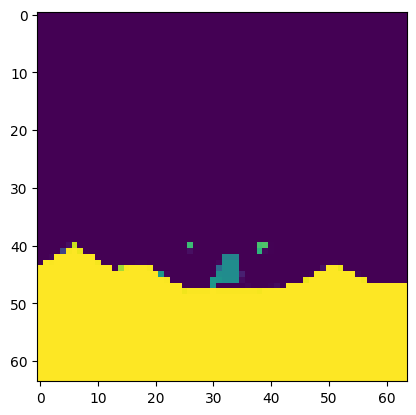

In [39]:
plt.imshow(np.squeeze(data[1]))

<AxesSubplot: xlabel='label', ylabel='count'>

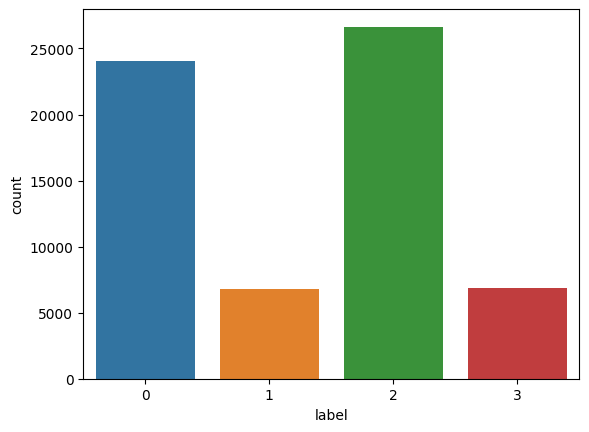

In [40]:
# Extract the lables from the last characters in the filename
labels = []
for i in image_filenames:
    l = i[-6:-5]
    labels.append(int(l))
        
# Count the number of clases
num_classes = len(set(labels))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(labels, num_classes)

# Plot a bar plot of the 
df = pd.DataFrame(labels, columns = ['label'])
sns.countplot(x=df["label"])

In [41]:
train, test, train_labels, test_labels = train_test_split(data, labels, random_state=0, test_size = 0.2, train_size = 0.8)
train_labels_wide = keras.utils.to_categorical(train_labels, num_classes)
test_labels_wide = keras.utils.to_categorical(test_labels, num_classes)

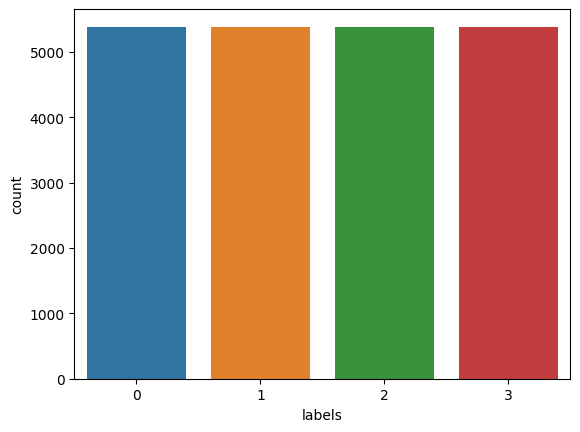

In [49]:
# Apply the random under-sampling
rus = RandomUnderSampler()
train_rus, train_labels_rus = rus.fit_resample(train.reshape(len(train), ROWS*COLS*CHANNELS), train_labels)
train_rus, train_labels_rus = shuffle(train_rus, train_labels_rus)
train_rus = train_rus.reshape(len(train_rus), ROWS, COLS, CHANNELS)
df2 = pd.DataFrame(train_labels_rus, columns=["labels"])
sns.countplot(x=df2['labels'])
train_labels_rus_wide = keras.utils.to_categorical(train_labels_rus, num_classes)

Trying out a couple of model architectures

First architecture:

In [50]:
#first model:

model1 = Sequential()

# model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(CHANNELS, ROWS, COLS), activation='relu'))
model1.add(Conv2D(32, (3, 3), padding='same', input_shape=(ROWS, COLS, CHANNELS), activation='relu', data_format='channels_last'))
model1.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_last'))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(num_classes, activation = 'softmax'))

model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                     

In [51]:
model1.compile(loss='categorical_crossentropy', optimizer=adam(learning_rate=1e-3), metrics=['accuracy'])

In [53]:
epochs = 20
batch_size = 256

history1 = model1.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Epoch 1/20
64/64 [==============================] - 10s 155ms/step - loss: 1.3423 - accuracy: 0.3512 - val_loss: 1.2156 - val_accuracy: 0.4457
Epoch 2/20
64/64 [==============================] - 10s 151ms/step - loss: 1.2028 - accuracy: 0.4338 - val_loss: 1.1291 - val_accuracy: 0.4904
Epoch 3/20
64/64 [==============================] - 11s 165ms/step - loss: 1.1425 - accuracy: 0.4593 - val_loss: 1.0633 - val_accuracy: 0.5114
Epoch 4/20
64/64 [==============================] - 11s 170ms/step - loss: 1.0981 - accuracy: 0.4807 - val_loss: 1.0376 - val_accuracy: 0.5146
Epoch 5/20
64/64 [==============================] - 11s 168ms/step - loss: 1.0683 - accuracy: 0.4867 - val_loss: 1.0051 - val_accuracy: 0.5228
Epoch 6/20
64/64 [==============================] - 11s 168ms/step - loss: 1.0496 - accuracy: 0.4999 - val_loss: 1.0053 - val_accuracy: 0.5228
Epoch 7/20
64/64 [==============================] - 11s 169ms/step - loss: 1.0302 - accuracy: 0.5055 - val_loss: 0.9902 - val_accuracy: 0.5215

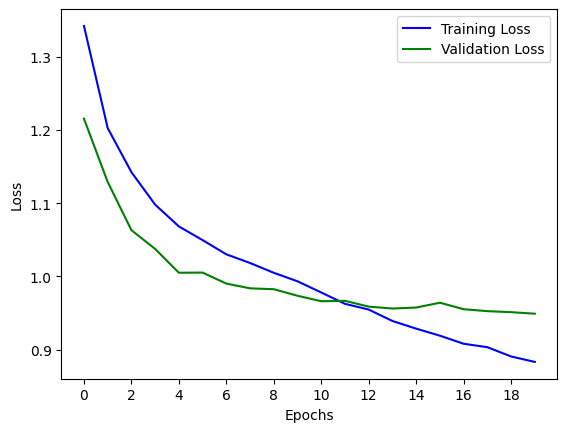

In [54]:
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss1, 'blue', label='Training Loss')
plt.plot(val_loss1, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

Second architecture:

In [56]:
model2 = Sequential()
model2.add(Flatten(input_shape=(ROWS, COLS, CHANNELS)))
model2.add(Dense(16))
model2.add(Activation('relu'))
model2.add(Dense(16))
model2.add(Activation('relu'))
model2.add(Dense(16))
model2.add(Activation('relu'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

model2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 4096)              0         
                                                                 
 dense_12 (Dense)            (None, 16)                65552     
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)              

In [58]:
model2.compile(loss='categorical_crossentropy', optimizer=adam(learning_rate=1e-3), metrics=['accuracy'])

In [59]:
epochs = 20
batch_size = 256

history2 = model2.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Epoch 1/20
64/64 [==============================] - 1s 11ms/step - loss: 1.3903 - accuracy: 0.2515 - val_loss: 1.3809 - val_accuracy: 0.2855
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 1.3685 - accuracy: 0.3268 - val_loss: 1.3552 - val_accuracy: 0.2924
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 1.3301 - accuracy: 0.3582 - val_loss: 1.2922 - val_accuracy: 0.3972
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 1.2707 - accuracy: 0.3959 - val_loss: 1.2408 - val_accuracy: 0.4171
Epoch 5/20
64/64 [==============================] - 0s 4ms/step - loss: 1.2180 - accuracy: 0.4270 - val_loss: 1.1932 - val_accuracy: 0.4408
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 1.1746 - accuracy: 0.4615 - val_loss: 1.1850 - val_accuracy: 0.4644
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 1.1475 - accuracy: 0.4802 - val_loss: 1.1156 - val_accuracy: 0.4947
Epoch 8/20
64/64 [=

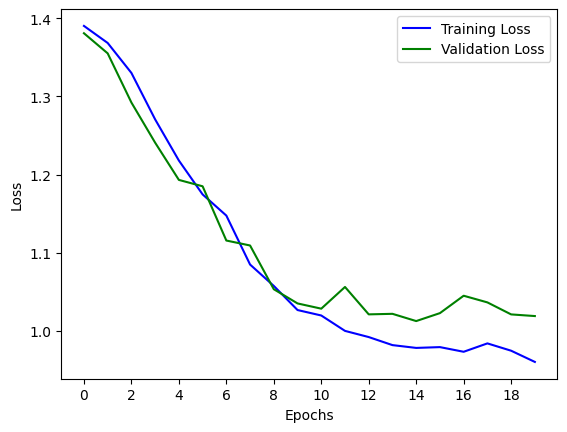

In [60]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss2, 'blue', label='Training Loss')
plt.plot(val_loss2, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

Third architecture:

In [62]:
model3 = Sequential()
model3.add(Conv2D(32, (8, 8), input_shape=(ROWS, COLS, CHANNELS), strides=(4, 4), data_format='channels_last'))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (4, 4), strides=(2, 2), data_format='channels_last'))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3), strides=(1, 1), data_format='channels_last'))
model3.add(Activation('relu'))
model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))
print(model3.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 15, 15, 32)        2080      
                                                                 
 activation_9 (Activation)   (None, 15, 15, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 6, 6, 64)          32832     
                                                                 
 activation_10 (Activation)  (None, 6, 6, 64)          0         
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 activation_11 (Activation)  (None, 4, 4, 64)          0         
                                                                 
 flatten_8 (Flatten)         (None, 1024)            

In [64]:
model3.compile(loss='categorical_crossentropy', optimizer=adam(learning_rate=1e-3), metrics=['accuracy'])

In [65]:
epochs = 20
batch_size = 256

history3 = model3.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Epoch 1/20
64/64 [==============================] - 2s 28ms/step - loss: 1.2073 - accuracy: 0.4101 - val_loss: 1.0633 - val_accuracy: 0.4871
Epoch 2/20
64/64 [==============================] - 2s 24ms/step - loss: 1.0388 - accuracy: 0.4987 - val_loss: 1.0264 - val_accuracy: 0.5086
Epoch 3/20
64/64 [==============================] - 2s 25ms/step - loss: 1.0046 - accuracy: 0.5143 - val_loss: 1.0012 - val_accuracy: 0.5140
Epoch 4/20
64/64 [==============================] - 2s 25ms/step - loss: 0.9807 - accuracy: 0.5241 - val_loss: 1.0144 - val_accuracy: 0.5079
Epoch 5/20
64/64 [==============================] - 2s 24ms/step - loss: 0.9648 - accuracy: 0.5309 - val_loss: 0.9834 - val_accuracy: 0.5267
Epoch 6/20
64/64 [==============================] - 2s 25ms/step - loss: 0.9435 - accuracy: 0.5471 - val_loss: 0.9682 - val_accuracy: 0.5298
Epoch 7/20
64/64 [==============================] - 2s 24ms/step - loss: 0.9176 - accuracy: 0.5630 - val_loss: 0.9485 - val_accuracy: 0.5411
Epoch 8/20
64

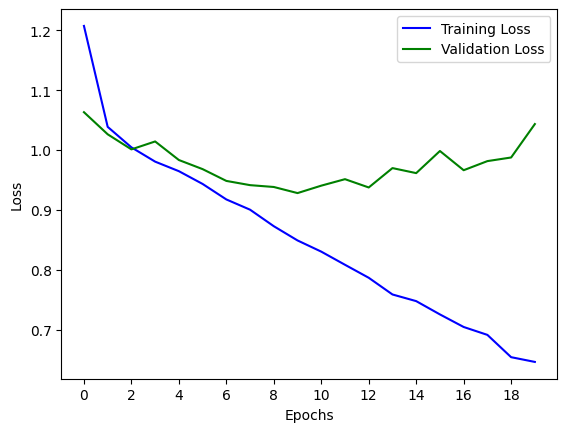

In [66]:
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss3, 'blue', label='Training Loss')
plt.plot(val_loss3, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

Fourth architecture


In [67]:
model4 = Sequential()

model4.add(Conv2D(32, (8,8),strides = (4,4), activation='relu', input_shape=(ROWS, COLS, CHANNELS), data_format='channels_last'))
model4.add(Dropout(0.5))
model4.add(Conv2D(64, (4,4),strides = (2,2), activation='relu', data_format='channels_last'))
model4.add(Dropout(0.5))
model4.add(Conv2D(64, (3,3),strides = (1,1), activation='relu', data_format='channels_last'))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(num_classes, activation='softmax'))

model4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 15, 15, 32)        2080      
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 6, 6, 64)          32832     
                                                                 
 dropout_7 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 conv2d_19 (Conv2D)          (None, 4, 4, 64)          36928     
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_20 (Dense)            (None, 128)             

In [68]:
model4.compile(loss='categorical_crossentropy', optimizer=adam(learning_rate=1e-3), metrics=['accuracy'])

In [69]:
epochs = 20
batch_size = 256

history4 = model4.fit(train_rus, train_labels_rus_wide, batch_size=batch_size, epochs=epochs, validation_split=0.25, verbose=1, shuffle=True)

Epoch 1/20
64/64 [==============================] - 3s 32ms/step - loss: 1.3873 - accuracy: 0.2490 - val_loss: 1.3865 - val_accuracy: 0.2422
Epoch 2/20
64/64 [==============================] - 2s 30ms/step - loss: 1.3860 - accuracy: 0.2543 - val_loss: 1.3826 - val_accuracy: 0.3338
Epoch 3/20
64/64 [==============================] - 2s 31ms/step - loss: 1.3000 - accuracy: 0.3452 - val_loss: 1.1889 - val_accuracy: 0.4130
Epoch 4/20
64/64 [==============================] - 2s 29ms/step - loss: 1.2060 - accuracy: 0.4056 - val_loss: 1.1428 - val_accuracy: 0.4252
Epoch 5/20
64/64 [==============================] - 2s 30ms/step - loss: 1.1480 - accuracy: 0.4442 - val_loss: 1.0614 - val_accuracy: 0.4960
Epoch 6/20
64/64 [==============================] - 2s 29ms/step - loss: 1.1001 - accuracy: 0.4783 - val_loss: 1.0336 - val_accuracy: 0.4962
Epoch 7/20
64/64 [==============================] - 2s 30ms/step - loss: 1.0739 - accuracy: 0.4810 - val_loss: 1.0228 - val_accuracy: 0.4995
Epoch 8/20
64

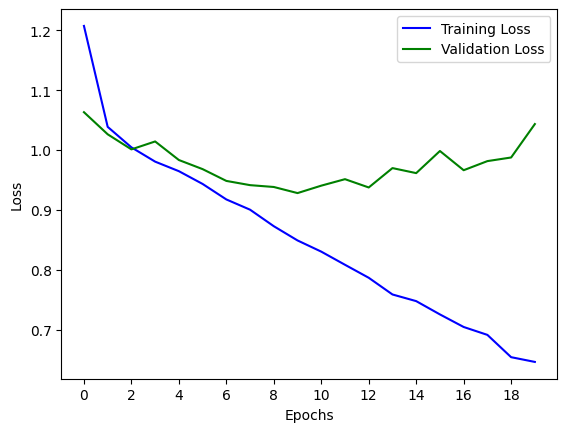

In [70]:
loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss3, 'blue', label='Training Loss')
plt.plot(val_loss3, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [71]:
A = {"Model 1": model1, " Model 2": model2, "Model 3": model3, "Model 4": model4}

In [83]:
# Evaluating the performance of all of the classifiers 
accuracy_table = pd.DataFrame(index = ["Accuracy"], columns=A.keys())
maximum = 0
for keys, items in A.items():
    # pred = items.predict_classes(test)
    pred = np.argmax(items.predict(test), axis=1)
    print("Confusion Matrix for", keys)
    print(metrics.confusion_matrix(test_labels, pred))
    print("Accuracy for", keys)
    X = metrics.accuracy_score(pred, test_labels)
    print(X, "\n")
    if X>maximum:
        maximum = X
        classifier = items
        name = keys
    accuracy_table.loc["Accuracy",keys] = X

403/403 [==============================] - 2s 6ms/step
Confusion Matrix for Model 1
[[2777  541  974  472]
 [ 245  991  139   27]
 [2841  607 1309  592]
 [ 339   32  106  873]]
Accuracy for Model 1
0.4624951418577536 

403/403 [==============================] - 0s 556us/step
Confusion Matrix for  Model 2
[[2030  632 1878  224]
 [ 230  995  152   25]
 [2088  719 2239  303]
 [ 341   88  217  704]]
Accuracy for  Model 2
0.4638942868247182 

403/403 [==============================] - 0s 1ms/step
Confusion Matrix for Model 3
[[1733 1099 1479  453]
 [ 105 1176  112    9]
 [1856 1249 1689  555]
 [ 215   42  177  916]]
Accuracy for Model 3
0.4286047415468325 

403/403 [==============================] - 0s 1ms/step
Confusion Matrix for Model 4
[[3022  494  833  415]
 [ 340  970   66   26]
 [3236  643  891  579]
 [ 298   45  179  828]]
Accuracy for Model 4
0.44391760590750096 



In [84]:
accuracy_table

,Model 1,Model 2,Model 3,Model 4
Accuracy,0.462495,0.463894,0.428605,0.443918


In [85]:
print("Best classifier is:", name, "with accuracy of:", maximum)
filepath = "task2.mod"
classifier.save(filepath)

Best classifier is:  Model 2 with accuracy of: 0.4638942868247182


FailedPreconditionError: task2.mod is not a directory